Machine Learning:- Email/SMS Spam Classifier

Checking the data

In [99]:
import pandas as pd
import numpy as np

In [100]:
df = pd.read_csv('D:/ML Project/spam.csv', encoding='ISO-8859-1')

In [101]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [102]:
df.shape    #number of rows and columns

(5572, 5)

1- Data Cleaning

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [104]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [105]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [106]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [107]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [108]:
df['target'] = encoder.fit_transform(df['target'])

In [109]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [110]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [111]:
df.duplicated().sum()

np.int64(403)

In [112]:
df.drop_duplicates(inplace=True)

In [113]:
df.shape

(5169, 2)

2- EDA(Exploratory Data Analysis)

In [114]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

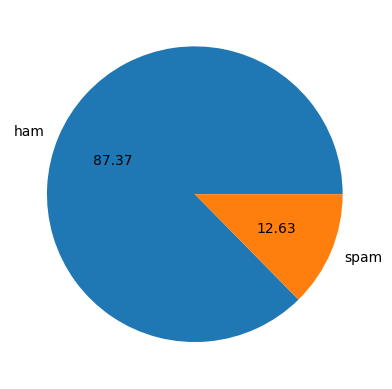

In [115]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

In [116]:
import nltk

In [117]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\clt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [118]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [119]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [120]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [121]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [122]:
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe() #ham

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [123]:
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe() #spam

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

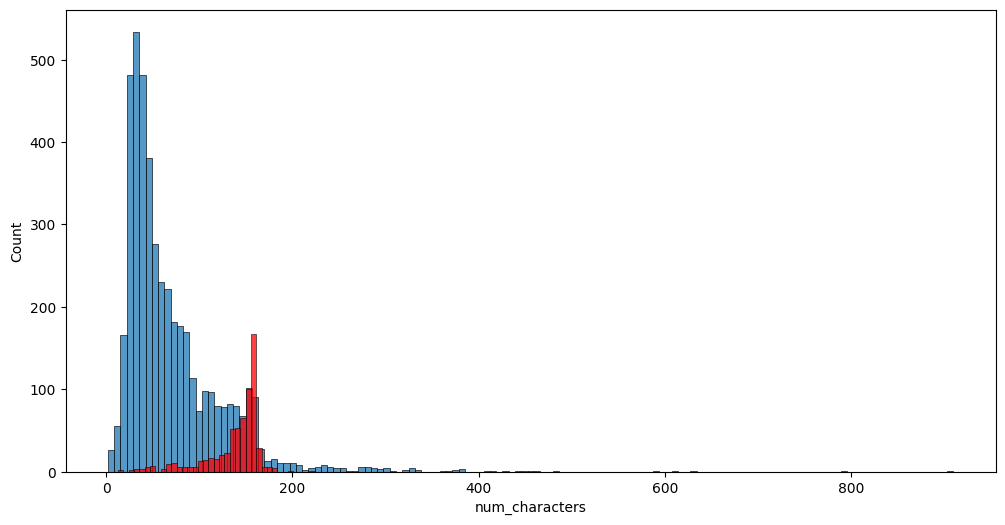

In [124]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

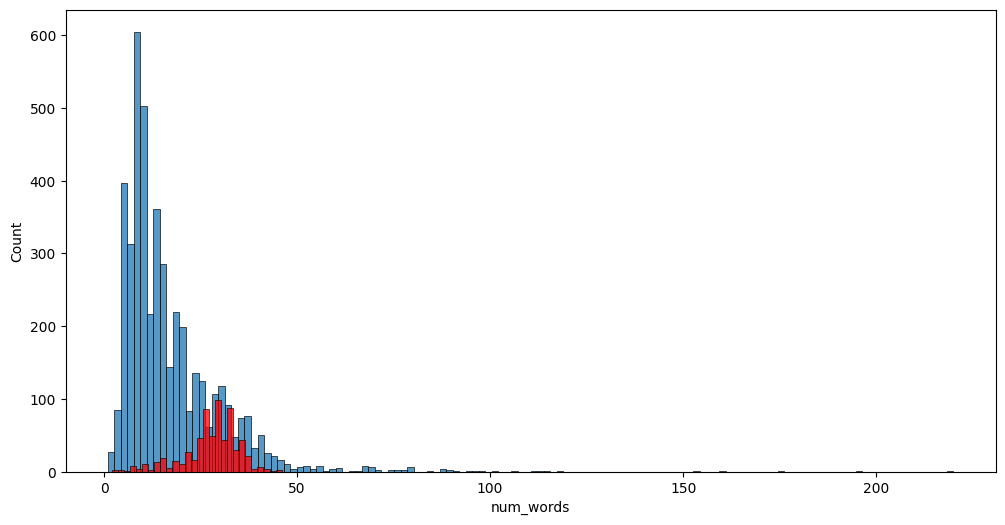

In [125]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

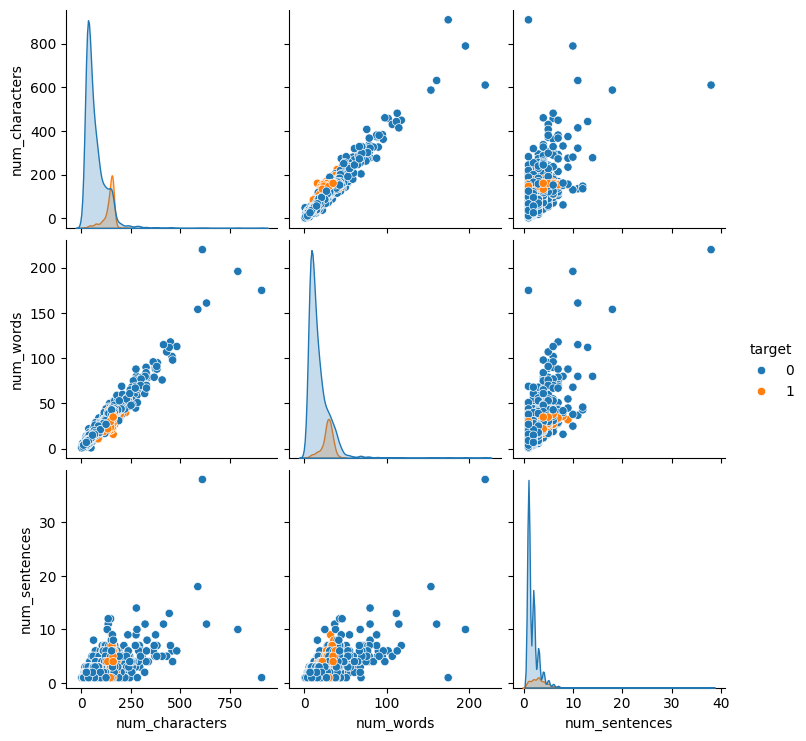

In [126]:
sns.pairplot(df, hue='target')

<Axes: >

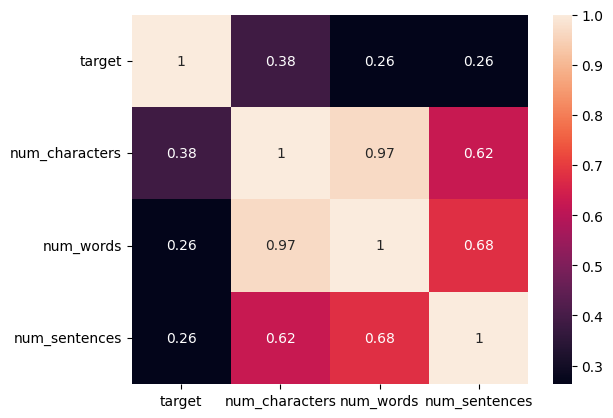

In [127]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

3- Data Preprocessing

In [128]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [129]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [130]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [131]:
# lower case and tokenization
def transform_text(text):
  text = text.lower()
  text = nltk.word_tokenize(text)

  y = []
  for i in text:         # to remove special characters
    if i.isalnum():
      y.append(i)

  text = y[:]
  y.clear()

  for i in text:
    if i not in stopwords.words('english') and i not in string.punctuation:
      y.append(i)

  text = y[:]
  y.clear()

  for i in text:
    y.append(ps.stem(i))

  return " ".join(y)
transform_text('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [132]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [135]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

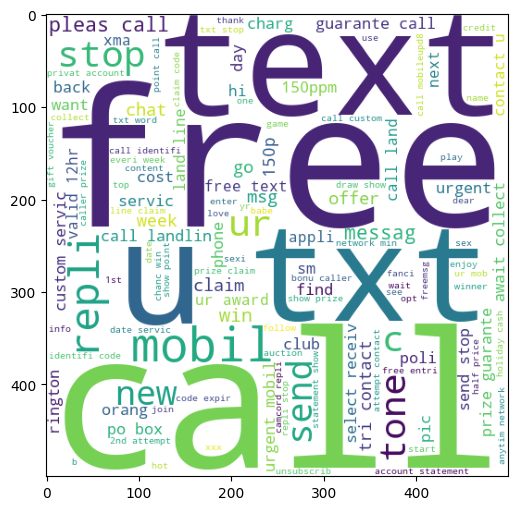

In [134]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

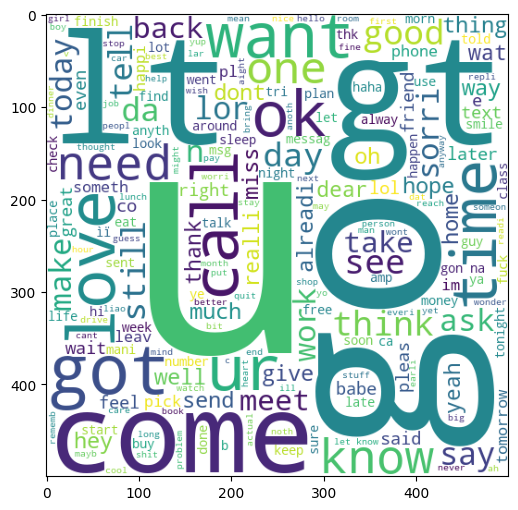

In [136]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [137]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
  for word in msg.split():
    spam_corpus.append(word)

In [39]:
len(spam_corpus)

9939

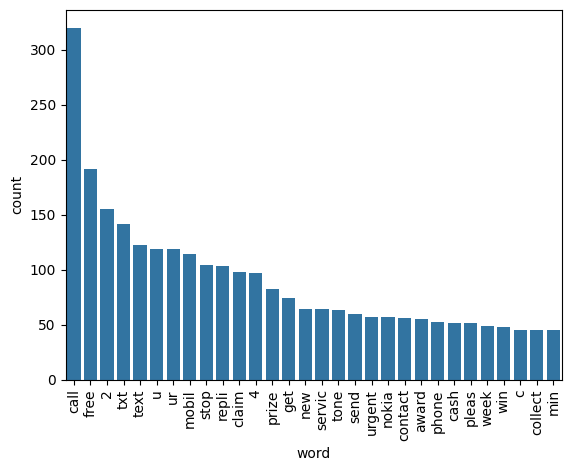

In [138]:
from collections import Counter
word_counts = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['word', 'count'])
sns.barplot(x='word', y='count', data=word_counts)
plt.xticks(rotation='vertical')
plt.show()

In [139]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
  for word in msg.split():
    ham_corpus.append(word)

In [140]:
len(ham_corpus)

35404

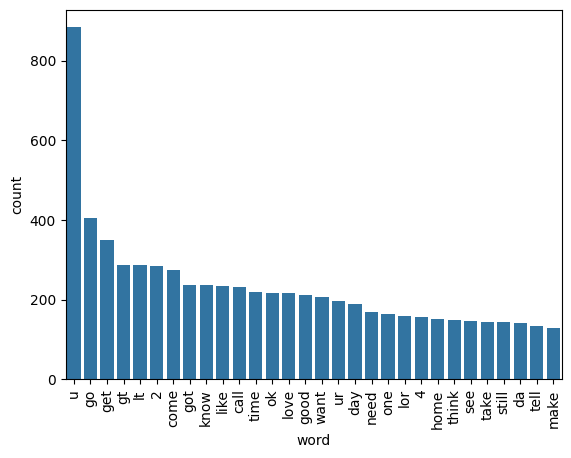

In [141]:
word_counts = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['word', 'count'])
sns.barplot(x='word', y='count', data=word_counts)
plt.xticks(rotation='vertical')
plt.show()

4- Model Building

In [428]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [429]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [430]:
# appending the num_character col to X
X = np.hstack((X, df['num_characters'].values.reshape(-1,1)))
X.shape

(5169, 3001)

In [431]:
y = df['target'].values
print(y)

[0 0 1 ... 0 0 0]


In [432]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [433]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [434]:
gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8936170212765957
[[808  88]
 [ 22 116]]
0.5686274509803921


In [435]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9400386847195358
[[896   0]
 [ 62  76]]
1.0


In [436]:
bnb.fit(X_train, y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [437]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [438]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators= 50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [439]:
clfs = { 
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [440]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  return accuracy, precision
train_classifier(svc,X_train,y_train,X_test,y_test)

c:\Users\clt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.8665377176015474, np.float64(0.0))

In [441]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
  current_accuracy, current_precision = train_classifier(clf, X_train, y_train, X_test, y_test)

  print("For ", name)
  print("Accuracy - ", current_accuracy)
  print("Precision - ", current_precision)

  accuracy_scores.append(current_accuracy)
  precision_scores.append(current_precision)

c:\Users\clt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


For  SVC
Accuracy -  0.8665377176015474
Precision -  0.0
For  KN
Accuracy -  0.937137330754352
Precision -  0.8543689320388349
For  NB
Accuracy -  0.9400386847195358
Precision -  1.0
For  DT
Accuracy -  0.9458413926499033
Precision -  0.8796296296296297
For  LR
Accuracy -  0.9593810444874274
Precision -  0.9528301886792453
For  RF
Accuracy -  0.9729206963249516
Precision -  0.9824561403508771


c:\Users\clt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


For  AdaBoost
Accuracy -  0.9613152804642167
Precision -  0.9083333333333333
For  BgC
Accuracy -  0.960348162475822
Precision -  0.8646616541353384
For  ETC
Accuracy -  0.9806576402321083
Precision -  0.9836065573770492
For  GBDT
Accuracy -  0.9506769825918762
Precision -  0.9306930693069307
For  xgb
Accuracy -  0.9700193423597679
Precision -  0.9421487603305785


In [427]:
df_performance = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy':accuracy_scores, 'Precision':precision_scores}).sort_values('Precision', ascending=False)
print(df_performance)

   Algorithm  Accuracy  Precision
2         NB  0.867505   1.000000
5         RF  0.974855   0.991228
8        ETC  0.974855   0.974576
4         LR  0.959381   0.952830
10       xgb  0.968085   0.933884
9       GBDT  0.951644   0.931373
6   AdaBoost  0.964217   0.924370
7        BgC  0.962282   0.896000
3         DT  0.951644   0.885965
1         KN  0.936170   0.852941
0        SVC  0.866538   0.000000


In [389]:
performance_df1= pd.melt(df_performance, id_vars=["Algorithm"])
print(performance_df1)

   Algorithm   variable     value
0         NB   Accuracy  0.867505
1         RF   Accuracy  0.974855
2        ETC   Accuracy  0.974855
3         LR   Accuracy  0.959381
4        xgb   Accuracy  0.968085
5       GBDT   Accuracy  0.951644
6   AdaBoost   Accuracy  0.964217
7        BgC   Accuracy  0.962282
8         DT   Accuracy  0.951644
9         KN   Accuracy  0.936170
10       SVC   Accuracy  0.866538
11        NB  Precision  1.000000
12        RF  Precision  0.991228
13       ETC  Precision  0.974576
14        LR  Precision  0.952830
15       xgb  Precision  0.933884
16      GBDT  Precision  0.931373
17  AdaBoost  Precision  0.924370
18       BgC  Precision  0.896000
19        DT  Precision  0.885965
20        KN  Precision  0.852941
21       SVC  Precision  0.000000


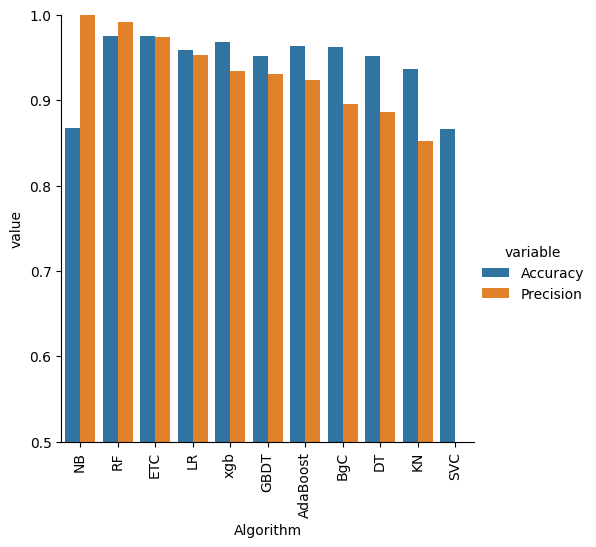

In [390]:
sns.catplot(x="Algorithm", y="value", hue="variable", data=performance_df1, kind="bar", height=5)
plt.ylim(0.5,1)
plt.xticks(rotation='vertical')
plt.show()

5- Model Performance Improvement

In [442]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy_max_ft_3000':accuracy_scores, 'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000', ascending=False)

In [392]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(), 'Accuracy':accuracy_scores, 'Precision':precision_scores}).sort_values('Precision', ascending=False)

In [443]:
performance_df.merge(temp_df, on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_max_ft_3000
0,NB,0.867505,1.000000,0.940039,1.000000
1,RF,0.974855,0.991228,0.972921,0.982456
2,ETC,0.974855,0.974576,0.980658,0.983607
3,LR,0.959381,0.952830,0.959381,0.952830
4,xgb,0.968085,0.933884,0.970019,0.942149
5,GBDT,0.951644,0.931373,0.950677,0.930693
6,AdaBoost,0.964217,0.924370,0.961315,0.908333
7,BgC,0.962282,0.896000,0.960348,0.864662
8,DT,0.951644,0.885965,0.945841,0.879630
9,KN,0.936170,0.852941,0.937137,0.854369


In [444]:
performance_df1= pd.melt(temp_df, id_vars=["Algorithm"])
print(performance_df1)

   Algorithm               variable     value
0         NB   Accuracy_max_ft_3000  0.940039
1        ETC   Accuracy_max_ft_3000  0.980658
2         RF   Accuracy_max_ft_3000  0.972921
3         LR   Accuracy_max_ft_3000  0.959381
4        xgb   Accuracy_max_ft_3000  0.970019
5       GBDT   Accuracy_max_ft_3000  0.950677
6   AdaBoost   Accuracy_max_ft_3000  0.961315
7         DT   Accuracy_max_ft_3000  0.945841
8        BgC   Accuracy_max_ft_3000  0.960348
9         KN   Accuracy_max_ft_3000  0.937137
10       SVC   Accuracy_max_ft_3000  0.866538
11        NB  Precision_max_ft_3000  1.000000
12       ETC  Precision_max_ft_3000  0.983607
13        RF  Precision_max_ft_3000  0.982456
14        LR  Precision_max_ft_3000  0.952830
15       xgb  Precision_max_ft_3000  0.942149
16      GBDT  Precision_max_ft_3000  0.930693
17  AdaBoost  Precision_max_ft_3000  0.908333
18        DT  Precision_max_ft_3000  0.879630
19       BgC  Precision_max_ft_3000  0.864662
20        KN  Precision_max_ft_300

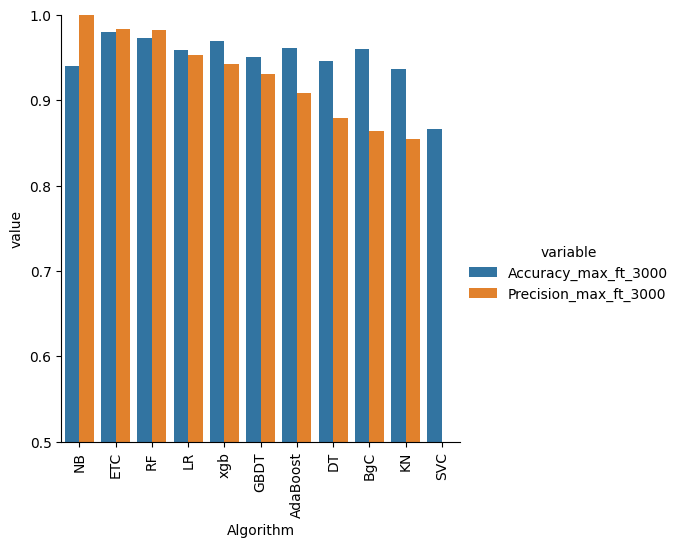

In [445]:
sns.catplot(x="Algorithm", y="value", hue="variable", data=performance_df1, kind="bar", height=5)
plt.ylim(0.5,1)
plt.xticks(rotation='vertical')
plt.show()

In [223]:
# voting classifier
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)], voting='soft')
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [224]:
y_pred = voting.predict(X_test)
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))

Accuracy 0.9429400386847195
Precision 1.0


In [226]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [227]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))

Accuracy 0.9777562862669246
Precision 0.9389312977099237


In [228]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

In [446]:
import pickle
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# تحميل الموارد
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()

def transform_text(text):
   
    text = text.lower()
  
    text = nltk.word_tokenize(text)
    
    y = [i for i in text if i.isalnum()]
    
    y = [i for i in y if i not in stopwords.words('english') and i not in string.punctuation]
 
    y = [ps.stem(i) for i in y]
    
    return " ".join(y)

data = df['transformed_text']
labels = df['target']  # 1 for spam, 0 for not spam

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data)  
y = labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = MultinomialNB()
model.fit(X_train, y_train)  

pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(model, open('model.pkl', 'wb'))


input_sms = input("Enter the message: ")

transformed_sms = transform_text(input_sms)

vector_input = tfidf.transform([transformed_sms])

result = model.predict(vector_input)[0]

if result == 1:
    print("Spam")
else:
    print("Not Spam")
    
# You have won a free lottery! Click here to claim. Spam
# Hey, are we still meeting for lunch today? Not Spam

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\clt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Spam
